<div style="text-align: right"><b> Ana Valentina López Chacón </b></div>
<div style="text-align: right"><b> Visión por Computadora, 2024 - 2025 </b></div>

## **Gender Recognition: EfficientNet**

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import Subset

from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from torchvision import transforms
from sklearn.metrics import f1_score
import copy
import random
from tqdm import tqdm
import multiprocessing
import timm

SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print("Torch version: ", torch. __version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Torch version:  2.6.0+cu124
Device:  cuda


### **Dataset**

In [2]:
os.system('wget -q https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz')
os.system('tar xvzf gender.tgz')

x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Training set class distribution: {sum(y_train == 1)}, {sum(y_train == 0)}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Test set class distribution: {sum(y_test == 1)}, {sum(y_test == 0)}")

./._x_test.npy
x_test.npy
./._x_train.npy
x_train.npy
./._y_test.npy
y_test.npy
./._y_train.npy
y_train.npy
x_train shape: (10585, 100, 100, 3)
y_train shape: (10585,)
Training set class distribution: 2381, 8204
x_test shape: (2648, 100, 100, 3)
y_test shape: (2648,)
Test set class distribution: 596, 2052


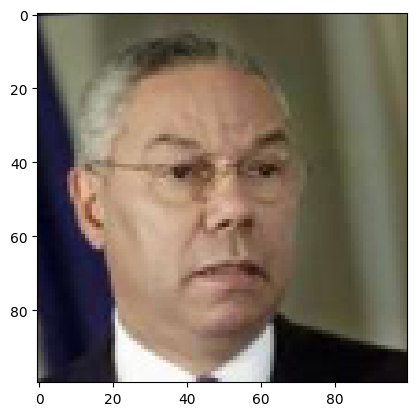

In [3]:
plt.imshow(x_train[0,:,:,:])
plt.show()

In [4]:
x_train = torch.from_numpy(x_train).permute(0, 3, 1, 2).float()  # [batch_size, 3, 100, 100]
x_test = torch.from_numpy(x_test).permute(0, 3, 1, 2).float()    # [batch_size, 3, 100, 100]

y_train = torch.from_numpy(y_train).long() 
y_test = torch.from_numpy(y_test).long()

In [5]:
class GenderDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        image = self.x_data[idx]
        label = self.y_data[idx]
        
        image = Image.fromarray(image.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [6]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = GenderDataset(x_train, y_train, transform=transform_train)
test_dataset = GenderDataset(x_test, y_test, transform=transform_test)

batch_size = 32
num_workers = multiprocessing.cpu_count()-1
print("Num workers", num_workers)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=num_workers)

Num workers 3


In [7]:
for images, labels in train_loader:
    print(f"Shape of images from DataLoader: {images.shape}")  # Should be [batch_size, 3, 224, 224]
    print(f"Shape of labels from DataLoader: {labels.shape}")  # Should be [batch_size, 1]
    break

Shape of images from DataLoader: torch.Size([32, 3, 224, 224])
Shape of labels from DataLoader: torch.Size([32])


### **Load Model**

In [8]:
timm.list_models('efficientnet*', pretrained=True)

['efficientnet_b0.ra4_e3600_r224_in1k',
 'efficientnet_b0.ra_in1k',
 'efficientnet_b1.ft_in1k',
 'efficientnet_b1.ra4_e3600_r240_in1k',
 'efficientnet_b1_pruned.in1k',
 'efficientnet_b2.ra_in1k',
 'efficientnet_b2_pruned.in1k',
 'efficientnet_b3.ra2_in1k',
 'efficientnet_b3_pruned.in1k',
 'efficientnet_b4.ra2_in1k',
 'efficientnet_b5.sw_in12k',
 'efficientnet_b5.sw_in12k_ft_in1k',
 'efficientnet_el.ra_in1k',
 'efficientnet_el_pruned.in1k',
 'efficientnet_em.ra2_in1k',
 'efficientnet_es.ra_in1k',
 'efficientnet_es_pruned.in1k',
 'efficientnet_lite0.ra_in1k',
 'efficientnetv2_rw_m.agc_in1k',
 'efficientnetv2_rw_s.ra2_in1k',
 'efficientnetv2_rw_t.ra2_in1k']

In [9]:
num_classes = 2
model = timm.create_model('efficientnetv2_rw_m.agc_in1k', pretrained=True, 
                          num_classes=num_classes)

model.classifier = nn.Linear(model.classifier.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, min_lr=0.00001)
epochs = 5

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Params: ", count_parameters(model))

model.safetensors:   0%|          | 0.00/214M [00:00<?, ?B/s]

Params:  51087748


### **Training**

In [10]:
model = model.to(device)
best_test_acc = 0.0
best_model_weights = None 

for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
        progress_bar.set_postfix(loss=loss.item())
    
    train_loss /= len(train_loader)
    train_acc = 100. * train_correct / len(train_dataset)
    
    model.eval()
    test_loss, test_correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_acc = 100. * test_correct / len(test_dataset)

    lr_scheduler.step(test_acc)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model_weights = copy.deepcopy(model.state_dict())
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "model_gender_efficientnet.pt")
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print("\nBest Test Accuracy: ", best_test_acc, " in epoch ", best_epoch)

Epoch 1/5: 100%|██████████| 331/331 [04:21<00:00,  1.27it/s, loss=0.0116] 


Epoch 1/5, Train Loss: 0.1554, Train Acc: 93.98%, Test Loss: 0.0684, Test Acc: 97.89%


Epoch 2/5: 100%|██████████| 331/331 [04:32<00:00,  1.21it/s, loss=0.0113] 


Epoch 2/5, Train Loss: 0.0507, Train Acc: 98.27%, Test Loss: 0.0544, Test Acc: 98.15%


Epoch 3/5: 100%|██████████| 331/331 [04:33<00:00,  1.21it/s, loss=0.00223] 


Epoch 3/5, Train Loss: 0.0246, Train Acc: 99.11%, Test Loss: 0.0549, Test Acc: 98.23%


Epoch 4/5: 100%|██████████| 331/331 [04:33<00:00,  1.21it/s, loss=0.0521]  


Epoch 4/5, Train Loss: 0.0198, Train Acc: 99.41%, Test Loss: 0.1096, Test Acc: 97.17%


Epoch 5/5: 100%|██████████| 331/331 [04:33<00:00,  1.21it/s, loss=0.0968]  


Epoch 5/5, Train Loss: 0.0119, Train Acc: 99.63%, Test Loss: 0.0955, Test Acc: 97.92%

Best Test Accuracy:  98.22507552870091  in epoch  3


### **Evaluación**

In [11]:
model.load_state_dict(best_model_weights)
model.eval() 

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [12]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix  

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')  
cm = confusion_matrix(all_labels, all_preds)

print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final F1-score: {f1:.4f}")

Final Accuracy: 0.9823
Final F1-score: 0.9749


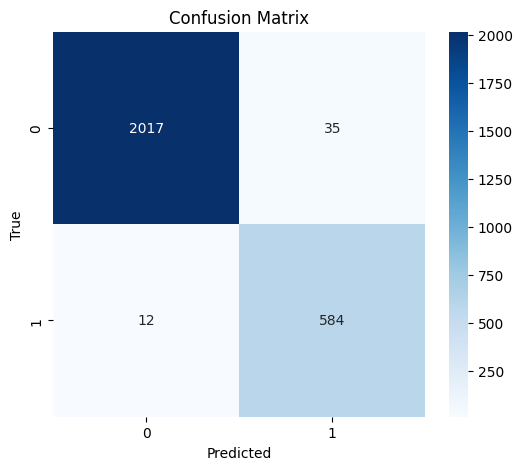

In [13]:
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()